In [19]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

from models import Asso, AssoOri, AssoExIterate
import pandas as pd
from utils import show_matrix

from cProfile import Profile
from pstats import SortKey, Stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate Boolean matrix

In [20]:
# generate arbitrary Boolean matrix (X)
from generators import BlockDiagonalMatrixGenerator, BlockMatrixGenerator

n_row=1000
n_col=500
k=5
overlap_flag=True
noise=[0.5, 0.2]
size_range=[0.25, 0.75, 0.25, 1.0]

X = BlockMatrixGenerator(m=n_row, n=n_col, k=k, overlap_flag=False, size_range=size_range)
X.generate(seed=1234) # if no seed assigned, use time instead
X.add_noise(noise=noise, seed=1024)
# X.show_matrix(scaling=0.2, title='arbitrary boolean matrix X')

[I] m            : 1000
[I] n            : 500
[I] k            : 5
[I] overlap_flag : False
[I] size_range   : [0.25 0.75 0.25 1.  ]
[I] seed         : 1234
[I] noise        : [0.5 0.2]
[I] seed         : 1024
[I] Using RandomState.


### Load MovieLens data

[I] Sampling axis 0 to size 500
[I]   sampling seed    : 1709108581
[I]   sampling from    : (943, 1682)
[I]              to    : (500, 1682)
[I] Sampling axis 0 with given indices
[I]   sampling from    : (943, 81)
[I]              to    : (500, 81)
[I] Sampling axis 1 to size 500
[I]   sampling seed    : 1709108581
[I]   sampling from    : (500, 1682)
[I]              to    : (500, 500)
[I] Sampling axis 1 with given indices
[I]   sampling from    : (26, 1682)
[I]              to    : (26, 500)
[I] Sampling axis 1 with given indices
[I]   sampling from    : (4708, 1682)
[I]              to    : (4708, 500)


[<500x500 sparse matrix of type '<class 'numpy.int32'>'
 	with 17372 stored elements in Compressed Sparse Row format>,
 <500x81 sparse matrix of type '<class 'numpy.float64'>'
 	with 1855 stored elements in Compressed Sparse Row format>,
 <26x500 sparse matrix of type '<class 'numpy.float64'>'
 	with 1217 stored elements in Compressed Sparse Row format>,
 <4708x500 sparse matrix of type '<class 'numpy.float64'>'
 	with 2487 stored elements in Compressed Sparse Row format>]

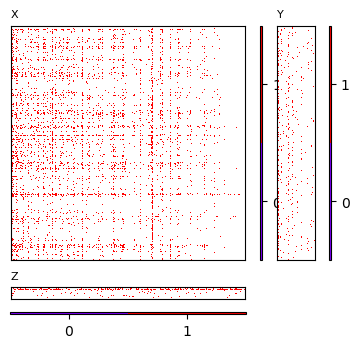

In [21]:
from datasets import MovieLensData, MovieLensGenreCastUserData

data = MovieLensGenreCastUserData(size='100k')

data.load()

data.sample(factor_id=0, n_samples=500)
data.sample(factor_id=1, n_samples=500)

display(data.Xs)

X, Y, Z, _ = data.Xs

show_matrix([(X, [0, 0], 'X'), (Y, [0, 1], 'Y'), (Z, [1, 0], 'Z')], 
            colorbar=True, keep_nan=True, discrete=True, center=True, clim=[0, 1], scaling=0.5)

In [22]:
from datasets import NoSplit, RatioSplit

split = RatioSplit(X=X, val_size=0.1, test_size=0.2, seed=1000)
split.negative_sample(train_size=split.pos_train_size, 
                      val_size=split.pos_val_size, 
                      test_size=split.pos_test_size, type='popularity')

X_train, X_val, X_test = split.X_train, split.X_val, split.X_test

[I] RatioSplit, sampling positives
[I]   seed         : 1000
[I]   train_size   : 12159
[I]   val_size     : 1738
[I]   test_size    : 3475
[I]   seed         : 1000
[I] RatioSplit, sampling negatives
[I]   all_negatives: 232628
[I]   n_negatives  : 17372
[I]   train_size   : 12159
[I]   val_size     : 1738
[I]   test_size    : 3475
[I]   seed         : 1000


c:\Users\nieht\miniconda3\envs\py39\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


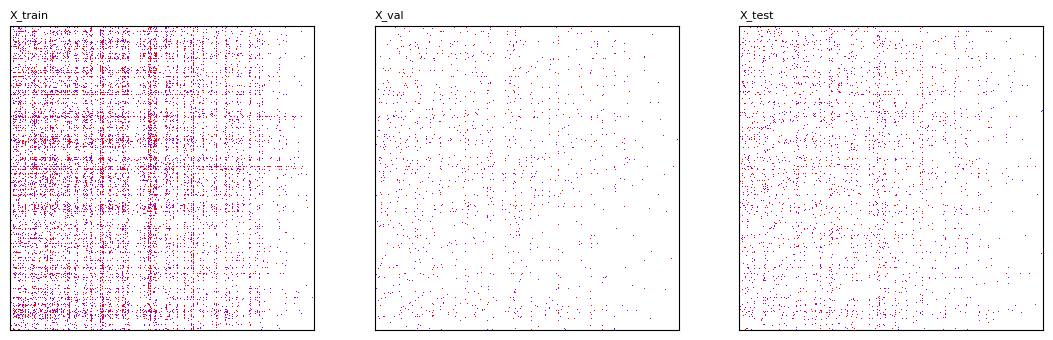

In [23]:
show_matrix(settings=[(X_train, [0, 0], 'X_train'), 
                      (X_val, [0, 1], 'X_val'), 
                      (X_test, [0, 2], 'X_test'), 
                      ], keep_nan=True, clim=[0, 1], discrete=True, center=True)

# Asso

[I] k            : 1
[I] verbose      : False
[I] display      : False
[I] tau          : 0.05
[I] weights      : 0.25
[I] task         : prediction
[I] verbose      : True
[I] display      : True


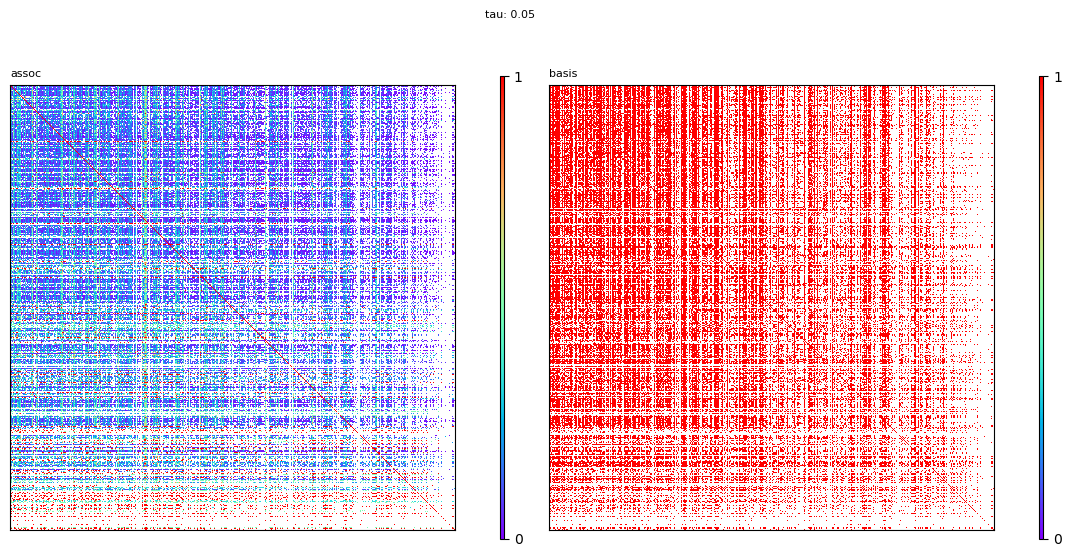

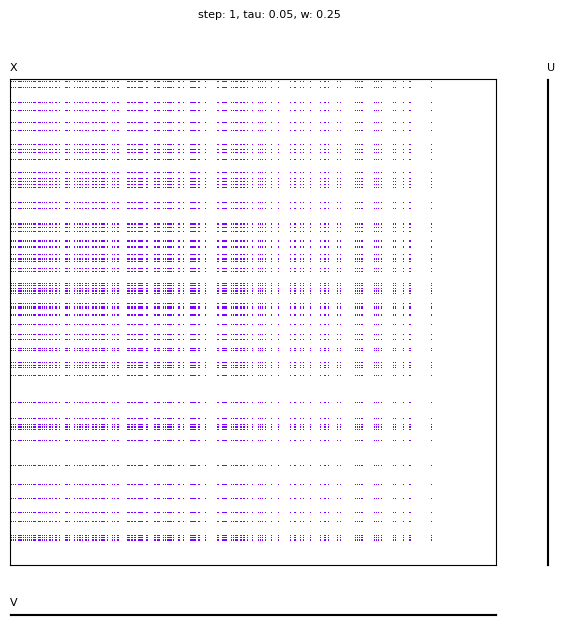

[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 35631.72it/s]

[I] Log dataframe: train_results


,time,cover_score,Recall,Precision,Accuracy,F1
0,28/02/24 04:23:10,853.0,0.279875,0.66621,0.569825,0.394162


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1665.96it/s]

[I] Log dataframe: val_results


,time,cover_score,Recall,Precision,Accuracy,F1
0,28/02/24 04:23:11,853.0,0.269275,0.655462,0.563867,0.381729


100%|██████████| 1/1 [00:09<00:00,  9.16s/it]


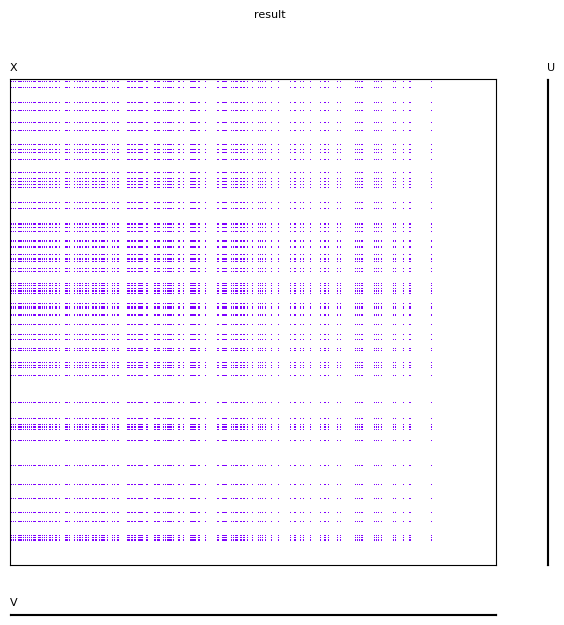

In [24]:
k = 1
tau = 0.05 # near-optimal: 0.15
w = 0.25

asso = Asso(k=k, tau=tau, w=w)
asso.fit(X_train, X_val, task='prediction', verbose=True, display=True)

In [25]:
# empty table
from utils import add_log

# metrics from sklearn is included for checking
metrics = ['Recall', 'Precision', 'Accuracy', 'F1', 
           'recall_score', 'precision_score', 'accuracy_score', 'f1_score']
columns = ['time', 'k', 'tau', 'w', 'X_train_cover'] + metrics
# df_prediction = pd.DataFrame(columns=columns)
df_reconstruction = pd.DataFrame(columns=columns)

results = asso.eval(X_val, metrics=metrics, task='prediction')
add_log(df_reconstruction, [pd.Timestamp.now(), k, tau, asso.w, asso.cover()] + results, verbose=True)

[I] Making predictions: 100%|██████████| 3476/3476 [00:01<00:00, 1742.47it/s]


,time,k,tau,w,X_train_cover,Recall,Precision,Accuracy,F1,recall_score,precision_score,accuracy_score,f1_score
0,2024-02-28 16:23:15.605520,1,0.05,0.25,853.0,0.269275,0.655462,0.563867,0.381729,0.269275,0.655462,0.563867,0.381729


In [26]:
from utils import matmul, fill_nan

U, V = asso.U, asso.V
X_pd = matmul(U, V.T, sparse=True, boolean=True)

X_train_pd = fill_nan(X_pd, X_train)
X_val_pd = fill_nan(X_pd, X_val)
X_test_pd = fill_nan(X_pd, X_test)

rng = [200, 200]
settings = [(X_train[:rng[0], :rng[1]],     [0, 0], 'X_train'), 
            (X_train_pd[:rng[0], :rng[1]],  [0, 1], 'X_train_pd'), 
            (X_val[:rng[0], :rng[1]],       [1, 0], 'X_val'), 
            (X_val_pd[:rng[0], :rng[1]],    [1, 1], 'X_val_pd'), 
            (X_test[:rng[0], :rng[1]],      [2, 0], 'X_test'), 
            (X_test_pd[:rng[0], :rng[1]],   [2, 1], 'X_test_pd'), 
            (X_pd[:rng[0], :rng[1]],        [1, 2], 'X_pd'), 
            ]

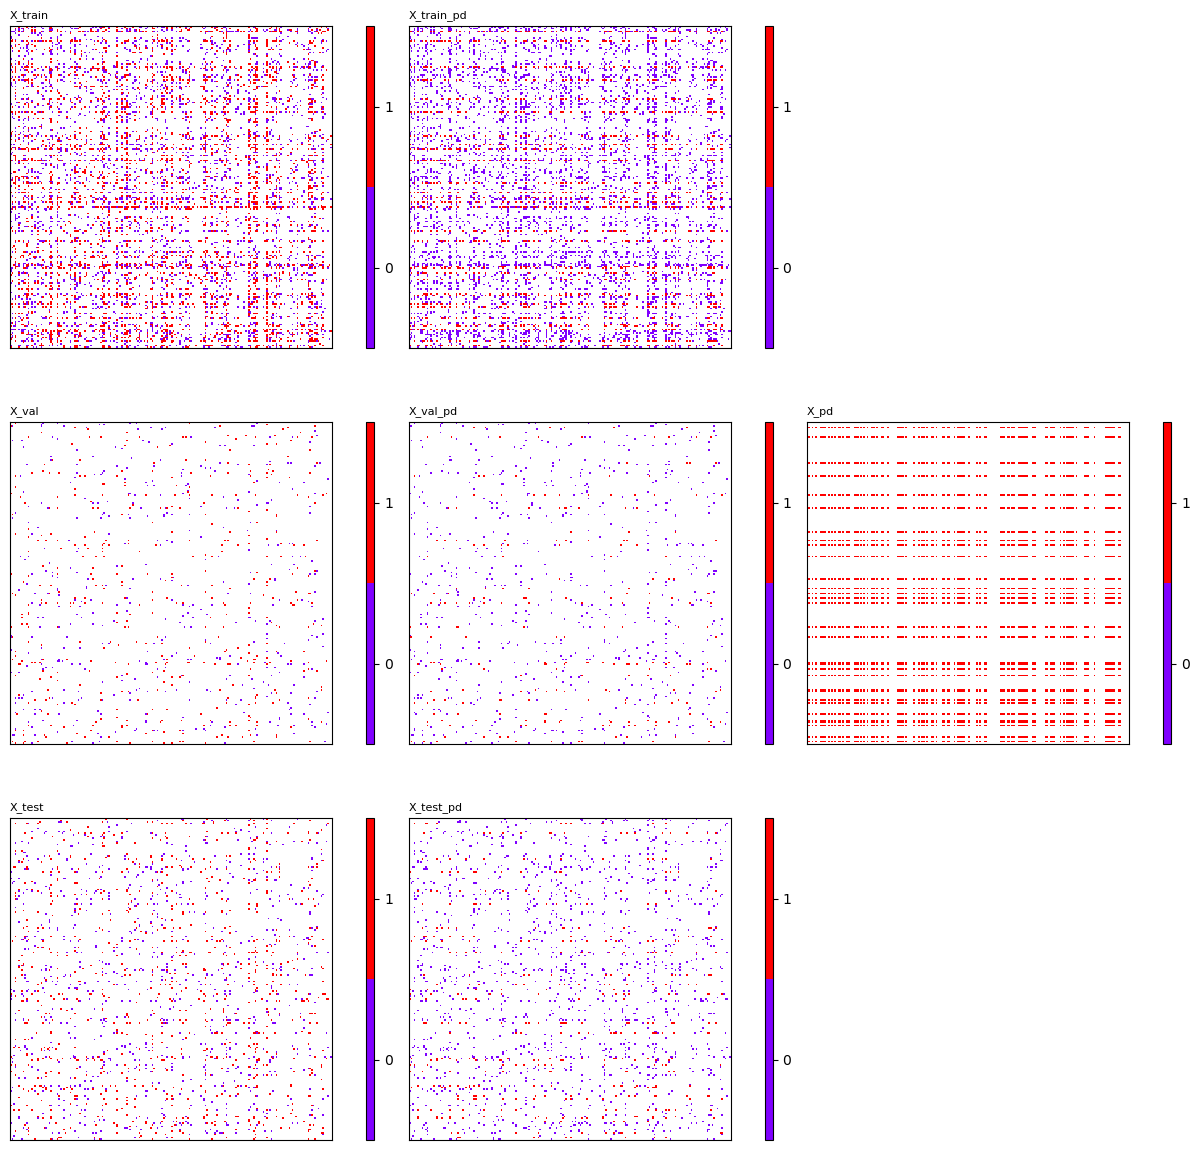

In [27]:
show_matrix(settings=settings, keep_nan=True, scaling=2, 
            clim=[0, 1], colorbar=True, discrete=True, center=True)

# AssoExIterative

In [37]:
k = 5
tau = 0.05
w = 0.25

asso = AssoExIterate(k=k, tau=tau, w=w)
asso.fit(X_train, X_val, task='prediction', display=True, verbose=True)

[I] k            : 5
[I] verbose      : False
[I] display      : False
[I] tau          : 0.05
[I] weights      : 0.25
[I] task         : prediction
[I] verbose      : True


k = 1 updated cols: 0 -> 853.0


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 36478.82it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
0,28/02/24 04:30:03,0,0,853.0,0.279875,0.66621,0.569825,0.394162


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1475.42it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
0,28/02/24 04:30:04,0,0,0.269275,0.655462,0.563867,0.381729


k = 1 updated rows: 853.0 -> 1356.5


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 42677.75it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
0,28/02/24 04:30:03,0,0,853.0,0.279875,0.666210,0.569825,0.394162
1,28/02/24 04:30:12,0,1,1356.5,0.292047,0.719263,0.589029,0.415419


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1627.29it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
0,28/02/24 04:30:04,0,0,0.269275,0.655462,0.563867,0.381729
1,28/02/24 04:30:13,0,1,0.262946,0.695586,0.573936,0.381628


k = 1 updated cols: 1356.5 -> 1437.0


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 42583.51it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
0,28/02/24 04:30:03,0,0,853.0,0.279875,0.666210,0.569825,0.394162
1,28/02/24 04:30:12,0,1,1356.5,0.292047,0.719263,0.589029,0.415419
2,28/02/24 04:30:22,0,2,1437.0,0.313595,0.716191,0.594662,0.436195


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1511.34it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
0,28/02/24 04:30:04,0,0,0.269275,0.655462,0.563867,0.381729
1,28/02/24 04:30:13,0,1,0.262946,0.695586,0.573936,0.381628
2,28/02/24 04:30:23,0,2,0.277330,0.677918,0.572785,0.393630


k = 1 updated rows: 1437.0 -> 1438.0


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 43906.94it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
0,28/02/24 04:30:03,0,0,853.0,0.279875,0.666210,0.569825,0.394162
1,28/02/24 04:30:12,0,1,1356.5,0.292047,0.719263,0.589029,0.415419
2,28/02/24 04:30:22,0,2,1437.0,0.313595,0.716191,0.594662,0.436195
3,28/02/24 04:30:32,0,3,1438.0,0.313677,0.715975,0.594621,0.436235


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1547.51it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
0,28/02/24 04:30:04,0,0,0.269275,0.655462,0.563867,0.381729
1,28/02/24 04:30:13,0,1,0.262946,0.695586,0.573936,0.381628
2,28/02/24 04:30:23,0,2,0.277330,0.677918,0.572785,0.393630
3,28/02/24 04:30:32,0,3,0.277330,0.678873,0.573072,0.393791


k = 1 updated cols: 1438.0 -> 1438.5


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 43640.42it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
0,28/02/24 04:30:03,0,0,853.0,0.279875,0.666210,0.569825,0.394162
1,28/02/24 04:30:12,0,1,1356.5,0.292047,0.719263,0.589029,0.415419
2,28/02/24 04:30:22,0,2,1437.0,0.313595,0.716191,0.594662,0.436195
3,28/02/24 04:30:32,0,3,1438.0,0.313677,0.715975,0.594621,0.436235
4,28/02/24 04:30:41,0,4,1438.5,0.312361,0.716874,0.594498,0.435126


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1533.28it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
0,28/02/24 04:30:04,0,0,0.269275,0.655462,0.563867,0.381729
1,28/02/24 04:30:13,0,1,0.262946,0.695586,0.573936,0.381628
2,28/02/24 04:30:23,0,2,0.277330,0.677918,0.572785,0.393630
3,28/02/24 04:30:32,0,3,0.277330,0.678873,0.573072,0.393791
4,28/02/24 04:30:42,0,4,0.275029,0.678977,0.572497,0.391482


k = 1 updated rows: 1438.5 -> 1438.75


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 38170.23it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
1,28/02/24 04:30:12,0,1,1356.50,0.292047,0.719263,0.589029,0.415419
2,28/02/24 04:30:22,0,2,1437.00,0.313595,0.716191,0.594662,0.436195
3,28/02/24 04:30:32,0,3,1438.00,0.313677,0.715975,0.594621,0.436235
4,28/02/24 04:30:41,0,4,1438.50,0.312361,0.716874,0.594498,0.435126
5,28/02/24 04:30:51,0,5,1438.75,0.315322,0.714898,0.594786,0.437621


[I] Making predictions: 100%|██████████| 3476/3476 [00:03<00:00, 1015.25it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
1,28/02/24 04:30:13,0,1,0.262946,0.695586,0.573936,0.381628
2,28/02/24 04:30:23,0,2,0.277330,0.677918,0.572785,0.393630
3,28/02/24 04:30:32,0,3,0.277330,0.678873,0.573072,0.393791
4,28/02/24 04:30:42,0,4,0.275029,0.678977,0.572497,0.391482
5,28/02/24 04:30:52,0,5,0.278481,0.680731,0.573936,0.395263


k = 1 updated cols: 1438.75 -> 1439.25


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 39474.76it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
2,28/02/24 04:30:22,0,2,1437.00,0.313595,0.716191,0.594662,0.436195
3,28/02/24 04:30:32,0,3,1438.00,0.313677,0.715975,0.594621,0.436235
4,28/02/24 04:30:41,0,4,1438.50,0.312361,0.716874,0.594498,0.435126
5,28/02/24 04:30:51,0,5,1438.75,0.315322,0.714898,0.594786,0.437621
6,28/02/24 04:31:03,0,6,1439.25,0.318118,0.714048,0.595361,0.440146


[I] Making predictions: 100%|██████████| 3476/3476 [00:03<00:00, 909.91it/s] 

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
2,28/02/24 04:30:23,0,2,0.277330,0.677918,0.572785,0.393630
3,28/02/24 04:30:32,0,3,0.277330,0.678873,0.573072,0.393791
4,28/02/24 04:30:42,0,4,0.275029,0.678977,0.572497,0.391482
5,28/02/24 04:30:52,0,5,0.278481,0.680731,0.573936,0.395263
6,28/02/24 04:31:04,0,6,0.280783,0.680614,0.574511,0.397556


k = 1 break_counter = 0


k = 1 break_counter = 1


[I] Making predictions: 100%|██████████| 24318/24318 [00:01<00:00, 14890.99it/s]

[I] Log dataframe: results_X_train


,time,k,score,Recall,Precision,Accuracy,F1
0,28/02/24 04:31:26,0,1439.25,0.318118,0.714048,0.595361,0.440146


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1422.05it/s]

[I] Log dataframe: results_X_val


,time,k,Recall,Precision,Accuracy,F1
0,28/02/24 04:31:28,0,0.280783,0.680614,0.574511,0.397556


k = 2 updated cols: 1439.25 -> 1544.5


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 41115.94it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
3,28/02/24 04:30:32,0,3,1438.00,0.313677,0.715975,0.594621,0.436235
4,28/02/24 04:30:41,0,4,1438.50,0.312361,0.716874,0.594498,0.435126
5,28/02/24 04:30:51,0,5,1438.75,0.315322,0.714898,0.594786,0.437621
6,28/02/24 04:31:03,0,6,1439.25,0.318118,0.714048,0.595361,0.440146
7,28/02/24 04:31:37,1,0,1544.50,0.340571,0.715817,0.602681,0.461547


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1368.05it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
3,28/02/24 04:30:32,0,3,0.277330,0.678873,0.573072,0.393791
4,28/02/24 04:30:42,0,4,0.275029,0.678977,0.572497,0.391482
5,28/02/24 04:30:52,0,5,0.278481,0.680731,0.573936,0.395263
6,28/02/24 04:31:04,0,6,0.280783,0.680614,0.574511,0.397556
7,28/02/24 04:31:37,1,0,0.297468,0.679369,0.578539,0.413766


k = 2 updated rows: 1544.5 -> 1606.25


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 43058.46it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
4,28/02/24 04:30:41,0,4,1438.50,0.312361,0.716874,0.594498,0.435126
5,28/02/24 04:30:51,0,5,1438.75,0.315322,0.714898,0.594786,0.437621
6,28/02/24 04:31:03,0,6,1439.25,0.318118,0.714048,0.595361,0.440146
7,28/02/24 04:31:37,1,0,1544.50,0.340571,0.715817,0.602681,0.461547
8,28/02/24 04:31:47,1,1,1606.25,0.364010,0.716297,0.609919,0.482713


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1413.60it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
4,28/02/24 04:30:42,0,4,0.275029,0.678977,0.572497,0.391482
5,28/02/24 04:30:52,0,5,0.278481,0.680731,0.573936,0.395263
6,28/02/24 04:31:04,0,6,0.280783,0.680614,0.574511,0.397556
7,28/02/24 04:31:37,1,0,0.297468,0.679369,0.578539,0.413766
8,28/02/24 04:31:47,1,1,0.317606,0.682324,0.584868,0.433451


k = 2 updated cols: 1606.25 -> 1650.75


[I] Making predictions: 100%|██████████| 24318/24318 [00:02<00:00, 10710.99it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
5,28/02/24 04:30:51,0,5,1438.75,0.315322,0.714898,0.594786,0.437621
6,28/02/24 04:31:03,0,6,1439.25,0.318118,0.714048,0.595361,0.440146
7,28/02/24 04:31:37,1,0,1544.50,0.340571,0.715817,0.602681,0.461547
8,28/02/24 04:31:47,1,1,1606.25,0.364010,0.716297,0.609919,0.482713
9,28/02/24 04:32:15,1,2,1650.75,0.379554,0.709563,0.612098,0.494561


[I] Making predictions: 100%|██████████| 3476/3476 [00:06<00:00, 565.43it/s] 


[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
5,28/02/24 04:30:52,0,5,0.278481,0.680731,0.573936,0.395263
6,28/02/24 04:31:04,0,6,0.280783,0.680614,0.574511,0.397556
7,28/02/24 04:31:37,1,0,0.297468,0.679369,0.578539,0.413766
8,28/02/24 04:31:47,1,1,0.317606,0.682324,0.584868,0.433451
9,28/02/24 04:32:17,1,2,0.332566,0.677608,0.587169,0.446160


k = 2 updated rows: 1650.75 -> 1689.0


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 36689.23it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
6,28/02/24 04:31:03,0,6,1439.25,0.318118,0.714048,0.595361,0.440146
7,28/02/24 04:31:37,1,0,1544.50,0.340571,0.715817,0.602681,0.461547
8,28/02/24 04:31:47,1,1,1606.25,0.364010,0.716297,0.609919,0.482713
9,28/02/24 04:32:15,1,2,1650.75,0.379554,0.709563,0.612098,0.494561
10,28/02/24 04:32:36,1,3,1689.00,0.373879,0.717035,0.613167,0.491486


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1552.14it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
6,28/02/24 04:31:04,0,6,0.280783,0.680614,0.574511,0.397556
7,28/02/24 04:31:37,1,0,0.297468,0.679369,0.578539,0.413766
8,28/02/24 04:31:47,1,1,0.317606,0.682324,0.584868,0.433451
9,28/02/24 04:32:17,1,2,0.332566,0.677608,0.587169,0.446160
10,28/02/24 04:32:37,1,3,0.327963,0.683453,0.588032,0.443235


k = 2 updated cols: 1689.0 -> 1735.5


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 28440.08it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
7,28/02/24 04:31:37,1,0,1544.50,0.340571,0.715817,0.602681,0.461547
8,28/02/24 04:31:47,1,1,1606.25,0.364010,0.716297,0.609919,0.482713
9,28/02/24 04:32:15,1,2,1650.75,0.379554,0.709563,0.612098,0.494561
10,28/02/24 04:32:36,1,3,1689.00,0.373879,0.717035,0.613167,0.491486
11,28/02/24 04:32:47,1,4,1735.50,0.399128,0.719069,0.621597,0.513328


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1369.73it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
7,28/02/24 04:31:37,1,0,0.297468,0.679369,0.578539,0.413766
8,28/02/24 04:31:47,1,1,0.317606,0.682324,0.584868,0.433451
9,28/02/24 04:32:17,1,2,0.332566,0.677608,0.587169,0.446160
10,28/02/24 04:32:37,1,3,0.327963,0.683453,0.588032,0.443235
11,28/02/24 04:32:48,1,4,0.349252,0.682790,0.593498,0.462124


k = 2 updated rows: 1735.5 -> 1750.75


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 39739.26it/s]


[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
8,28/02/24 04:31:47,1,1,1606.25,0.364010,0.716297,0.609919,0.482713
9,28/02/24 04:32:15,1,2,1650.75,0.379554,0.709563,0.612098,0.494561
10,28/02/24 04:32:36,1,3,1689.00,0.373879,0.717035,0.613167,0.491486
11,28/02/24 04:32:47,1,4,1735.50,0.399128,0.719069,0.621597,0.513328
12,28/02/24 04:32:57,1,5,1750.75,0.393536,0.722591,0.621227,0.509558


[I] Making predictions: 100%|██████████| 3476/3476 [00:03<00:00, 1009.39it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
8,28/02/24 04:31:47,1,1,0.317606,0.682324,0.584868,0.433451
9,28/02/24 04:32:17,1,2,0.332566,0.677608,0.587169,0.446160
10,28/02/24 04:32:37,1,3,0.327963,0.683453,0.588032,0.443235
11,28/02/24 04:32:48,1,4,0.349252,0.682790,0.593498,0.462124
12,28/02/24 04:32:58,1,5,0.344649,0.685355,0.593211,0.458652


k = 2 updated cols: 1750.75 -> 1758.75


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 33281.34it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
9,28/02/24 04:32:15,1,2,1650.75,0.379554,0.709563,0.612098,0.494561
10,28/02/24 04:32:36,1,3,1689.00,0.373879,0.717035,0.613167,0.491486
11,28/02/24 04:32:47,1,4,1735.50,0.399128,0.719069,0.621597,0.513328
12,28/02/24 04:32:57,1,5,1750.75,0.393536,0.722591,0.621227,0.509558
13,28/02/24 04:33:10,1,6,1758.75,0.401925,0.719947,0.622790,0.515860


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1374.33it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
9,28/02/24 04:32:17,1,2,0.332566,0.677608,0.587169,0.446160
10,28/02/24 04:32:37,1,3,0.327963,0.683453,0.588032,0.443235
11,28/02/24 04:32:48,1,4,0.349252,0.682790,0.593498,0.462124
12,28/02/24 04:32:58,1,5,0.344649,0.685355,0.593211,0.458652
13,28/02/24 04:33:11,1,6,0.350978,0.680804,0.593211,0.463174


k = 2 updated rows: 1758.75 -> 1759.25


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 40686.70it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
10,28/02/24 04:32:36,1,3,1689.00,0.373879,0.717035,0.613167,0.491486
11,28/02/24 04:32:47,1,4,1735.50,0.399128,0.719069,0.621597,0.513328
12,28/02/24 04:32:57,1,5,1750.75,0.393536,0.722591,0.621227,0.509558
13,28/02/24 04:33:10,1,6,1758.75,0.401925,0.719947,0.622790,0.515860
14,28/02/24 04:33:20,1,7,1759.25,0.399128,0.720671,0.622214,0.513735


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1392.09it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
10,28/02/24 04:32:37,1,3,0.327963,0.683453,0.588032,0.443235
11,28/02/24 04:32:48,1,4,0.349252,0.682790,0.593498,0.462124
12,28/02/24 04:32:58,1,5,0.344649,0.685355,0.593211,0.458652
13,28/02/24 04:33:11,1,6,0.350978,0.680804,0.593211,0.463174
14,28/02/24 04:33:21,1,7,0.346375,0.679458,0.591484,0.458841


k = 2 updated cols: 1759.25 -> 1761.75


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 40478.65it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
11,28/02/24 04:32:47,1,4,1735.50,0.399128,0.719069,0.621597,0.513328
12,28/02/24 04:32:57,1,5,1750.75,0.393536,0.722591,0.621227,0.509558
13,28/02/24 04:33:10,1,6,1758.75,0.401925,0.719947,0.622790,0.515860
14,28/02/24 04:33:20,1,7,1759.25,0.399128,0.720671,0.622214,0.513735
15,28/02/24 04:33:30,1,8,1761.75,0.397977,0.720948,0.621967,0.512850


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1432.89it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
11,28/02/24 04:32:48,1,4,0.349252,0.682790,0.593498,0.462124
12,28/02/24 04:32:58,1,5,0.344649,0.685355,0.593211,0.458652
13,28/02/24 04:33:11,1,6,0.350978,0.680804,0.593211,0.463174
14,28/02/24 04:33:21,1,7,0.346375,0.679458,0.591484,0.458841
15,28/02/24 04:33:30,1,8,0.346375,0.681767,0.592348,0.459367


k = 2 break_counter = 0


k = 2 break_counter = 1


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 34009.44it/s]

[I] Log dataframe: results_X_train


,time,k,score,Recall,Precision,Accuracy,F1
0,28/02/24 04:31:26,0,1439.25,0.318118,0.714048,0.595361,0.440146
1,28/02/24 04:33:48,1,1761.75,0.397977,0.720948,0.621967,0.512850


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1277.28it/s]


[I] Log dataframe: results_X_val


,time,k,Recall,Precision,Accuracy,F1
0,28/02/24 04:31:28,0,0.280783,0.680614,0.574511,0.397556
1,28/02/24 04:33:49,1,0.346375,0.681767,0.592348,0.459367


k = 3 updated cols: 1761.75 -> 1961.25


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 32400.75it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
12,28/02/24 04:32:57,1,5,1750.75,0.393536,0.722591,0.621227,0.509558
13,28/02/24 04:33:10,1,6,1758.75,0.401925,0.719947,0.622790,0.515860
14,28/02/24 04:33:20,1,7,1759.25,0.399128,0.720671,0.622214,0.513735
15,28/02/24 04:33:30,1,8,1761.75,0.397977,0.720948,0.621967,0.512850
16,28/02/24 04:34:00,2,0,1961.25,0.452175,0.726768,0.641089,0.557493


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1520.21it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
12,28/02/24 04:32:58,1,5,0.344649,0.685355,0.593211,0.458652
13,28/02/24 04:33:11,1,6,0.350978,0.680804,0.593211,0.463174
14,28/02/24 04:33:21,1,7,0.346375,0.679458,0.591484,0.458841
15,28/02/24 04:33:30,1,8,0.346375,0.681767,0.592348,0.459367
16,28/02/24 04:34:01,2,0,0.392980,0.678252,0.603280,0.497632


k = 3 updated rows: 1961.25 -> 1969.25


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 38878.47it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
13,28/02/24 04:33:10,1,6,1758.75,0.401925,0.719947,0.622790,0.515860
14,28/02/24 04:33:20,1,7,1759.25,0.399128,0.720671,0.622214,0.513735
15,28/02/24 04:33:30,1,8,1761.75,0.397977,0.720948,0.621967,0.512850
16,28/02/24 04:34:00,2,0,1961.25,0.452175,0.726768,0.641089,0.557493
17,28/02/24 04:34:10,2,1,1969.25,0.450613,0.728203,0.641212,0.556724


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1408.90it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
13,28/02/24 04:33:11,1,6,0.350978,0.680804,0.593211,0.463174
14,28/02/24 04:33:21,1,7,0.346375,0.679458,0.591484,0.458841
15,28/02/24 04:33:30,1,8,0.346375,0.681767,0.592348,0.459367
16,28/02/24 04:34:01,2,0,0.392980,0.678252,0.603280,0.497632
17,28/02/24 04:34:11,2,1,0.391254,0.680000,0.603567,0.496713


k = 3 break_counter = 0


k = 3 break_counter = 1


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 28953.02it/s]

[I] Log dataframe: results_X_train


,time,k,score,Recall,Precision,Accuracy,F1
0,28/02/24 04:31:26,0,1439.25,0.318118,0.714048,0.595361,0.440146
1,28/02/24 04:33:48,1,1761.75,0.397977,0.720948,0.621967,0.512850
2,28/02/24 04:34:33,2,1969.25,0.450613,0.728203,0.641212,0.556724


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1245.32it/s]

[I] Log dataframe: results_X_val


,time,k,Recall,Precision,Accuracy,F1
0,28/02/24 04:31:28,0,0.280783,0.680614,0.574511,0.397556
1,28/02/24 04:33:49,1,0.346375,0.681767,0.592348,0.459367
2,28/02/24 04:34:34,2,0.391254,0.680000,0.603567,0.496713


k = 4 updated cols: 1969.25 -> 2040.0


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 38267.41it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
14,28/02/24 04:33:20,1,7,1759.25,0.399128,0.720671,0.622214,0.513735
15,28/02/24 04:33:30,1,8,1761.75,0.397977,0.720948,0.621967,0.512850
16,28/02/24 04:34:00,2,0,1961.25,0.452175,0.726768,0.641089,0.557493
17,28/02/24 04:34:10,2,1,1969.25,0.450613,0.728203,0.641212,0.556724
18,28/02/24 04:34:45,3,0,2040.00,0.471009,0.726869,0.647010,0.571614


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1420.80it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
14,28/02/24 04:33:21,1,7,0.346375,0.679458,0.591484,0.458841
15,28/02/24 04:33:30,1,8,0.346375,0.681767,0.592348,0.459367
16,28/02/24 04:34:01,2,0,0.392980,0.678252,0.603280,0.497632
17,28/02/24 04:34:11,2,1,0.391254,0.680000,0.603567,0.496713
18,28/02/24 04:34:45,3,0,0.408516,0.678776,0.607595,0.510057


k = 4 updated rows: 2040.0 -> 2066.25


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 38944.63it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
15,28/02/24 04:33:30,1,8,1761.75,0.397977,0.720948,0.621967,0.512850
16,28/02/24 04:34:00,2,0,1961.25,0.452175,0.726768,0.641089,0.557493
17,28/02/24 04:34:10,2,1,1969.25,0.450613,0.728203,0.641212,0.556724
18,28/02/24 04:34:45,3,0,2040.00,0.471009,0.726869,0.647010,0.571614
19,28/02/24 04:34:55,3,1,2066.25,0.475121,0.728224,0.648902,0.575055


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1380.34it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
15,28/02/24 04:33:30,1,8,0.346375,0.681767,0.592348,0.459367
16,28/02/24 04:34:01,2,0,0.392980,0.678252,0.603280,0.497632
17,28/02/24 04:34:11,2,1,0.391254,0.680000,0.603567,0.496713
18,28/02/24 04:34:45,3,0,0.408516,0.678776,0.607595,0.510057
19,28/02/24 04:34:55,3,1,0.410242,0.681644,0.609321,0.512213


k = 4 updated cols: 2066.25 -> 2071.25


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 41352.66it/s]


[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
16,28/02/24 04:34:00,2,0,1961.25,0.452175,0.726768,0.641089,0.557493
17,28/02/24 04:34:10,2,1,1969.25,0.450613,0.728203,0.641212,0.556724
18,28/02/24 04:34:45,3,0,2040.00,0.471009,0.726869,0.647010,0.571614
19,28/02/24 04:34:55,3,1,2066.25,0.475121,0.728224,0.648902,0.575055
20,28/02/24 04:35:04,3,2,2071.25,0.474463,0.728685,0.648902,0.574716


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1524.63it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
16,28/02/24 04:34:01,2,0,0.392980,0.678252,0.603280,0.497632
17,28/02/24 04:34:11,2,1,0.391254,0.680000,0.603567,0.496713
18,28/02/24 04:34:45,3,0,0.408516,0.678776,0.607595,0.510057
19,28/02/24 04:34:55,3,1,0.410242,0.681644,0.609321,0.512213
20,28/02/24 04:35:05,3,2,0.409666,0.681992,0.609321,0.511862


k = 4 updated rows: 2071.25 -> 2075.75


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 33683.98it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
17,28/02/24 04:34:10,2,1,1969.25,0.450613,0.728203,0.641212,0.556724
18,28/02/24 04:34:45,3,0,2040.00,0.471009,0.726869,0.647010,0.571614
19,28/02/24 04:34:55,3,1,2066.25,0.475121,0.728224,0.648902,0.575055
20,28/02/24 04:35:04,3,2,2071.25,0.474463,0.728685,0.648902,0.574716
21,28/02/24 04:35:14,3,3,2075.75,0.475697,0.729566,0.649683,0.575895


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1601.17it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
17,28/02/24 04:34:11,2,1,0.391254,0.680000,0.603567,0.496713
18,28/02/24 04:34:45,3,0,0.408516,0.678776,0.607595,0.510057
19,28/02/24 04:34:55,3,1,0.410242,0.681644,0.609321,0.512213
20,28/02/24 04:35:05,3,2,0.409666,0.681992,0.609321,0.511862
21,28/02/24 04:35:15,3,3,0.410242,0.682297,0.609609,0.512397


k = 4 updated cols: 2075.75 -> 2077.25


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 40328.16it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
18,28/02/24 04:34:45,3,0,2040.00,0.471009,0.726869,0.647010,0.571614
19,28/02/24 04:34:55,3,1,2066.25,0.475121,0.728224,0.648902,0.575055
20,28/02/24 04:35:04,3,2,2071.25,0.474463,0.728685,0.648902,0.574716
21,28/02/24 04:35:14,3,3,2075.75,0.475697,0.729566,0.649683,0.575895
22,28/02/24 04:35:24,3,4,2077.25,0.475697,0.729842,0.649807,0.575981


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1553.62it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
18,28/02/24 04:34:45,3,0,0.408516,0.678776,0.607595,0.510057
19,28/02/24 04:34:55,3,1,0.410242,0.681644,0.609321,0.512213
20,28/02/24 04:35:05,3,2,0.409666,0.681992,0.609321,0.511862
21,28/02/24 04:35:15,3,3,0.410242,0.682297,0.609609,0.512397
22,28/02/24 04:35:24,3,4,0.410817,0.683908,0.610472,0.513300


k = 4 break_counter = 0


k = 4 break_counter = 1


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 35255.45it/s]

[I] Log dataframe: results_X_train


,time,k,score,Recall,Precision,Accuracy,F1
0,28/02/24 04:31:26,0,1439.25,0.318118,0.714048,0.595361,0.440146
1,28/02/24 04:33:48,1,1761.75,0.397977,0.720948,0.621967,0.512850
2,28/02/24 04:34:33,2,1969.25,0.450613,0.728203,0.641212,0.556724
3,28/02/24 04:35:39,3,2077.25,0.475697,0.729842,0.649807,0.575981


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1221.78it/s]

[I] Log dataframe: results_X_val


,time,k,Recall,Precision,Accuracy,F1
0,28/02/24 04:31:28,0,0.280783,0.680614,0.574511,0.397556
1,28/02/24 04:33:49,1,0.346375,0.681767,0.592348,0.459367
2,28/02/24 04:34:34,2,0.391254,0.680000,0.603567,0.496713
3,28/02/24 04:35:40,3,0.410817,0.683908,0.610472,0.513300


k = 5 updated cols: 2077.25 -> 2151.25


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 29159.24it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
19,28/02/24 04:34:55,3,1,2066.25,0.475121,0.728224,0.648902,0.575055
20,28/02/24 04:35:04,3,2,2071.25,0.474463,0.728685,0.648902,0.574716
21,28/02/24 04:35:14,3,3,2075.75,0.475697,0.729566,0.649683,0.575895
22,28/02/24 04:35:24,3,4,2077.25,0.475697,0.729842,0.649807,0.575981
23,28/02/24 04:35:51,4,0,2151.25,0.493297,0.733162,0.656880,0.589774


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1175.25it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
19,28/02/24 04:34:55,3,1,0.410242,0.681644,0.609321,0.512213
20,28/02/24 04:35:05,3,2,0.409666,0.681992,0.609321,0.511862
21,28/02/24 04:35:15,3,3,0.410242,0.682297,0.609609,0.512397
22,28/02/24 04:35:24,3,4,0.410817,0.683908,0.610472,0.513300
23,28/02/24 04:35:52,4,0,0.416571,0.683664,0.611910,0.517698


k = 5 break_counter = 0


k = 5 updated cols: 2151.25 -> 2153.0


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 35923.00it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
20,28/02/24 04:35:04,3,2,2071.25,0.474463,0.728685,0.648902,0.574716
21,28/02/24 04:35:14,3,3,2075.75,0.475697,0.729566,0.649683,0.575895
22,28/02/24 04:35:24,3,4,2077.25,0.475697,0.729842,0.649807,0.575981
23,28/02/24 04:35:51,4,0,2151.25,0.493297,0.733162,0.656880,0.589774
24,28/02/24 04:36:10,4,1,2153.00,0.493133,0.732649,0.656592,0.589490


[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1365.74it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
20,28/02/24 04:35:05,3,2,0.409666,0.681992,0.609321,0.511862
21,28/02/24 04:35:15,3,3,0.410242,0.682297,0.609609,0.512397
22,28/02/24 04:35:24,3,4,0.410817,0.683908,0.610472,0.513300
23,28/02/24 04:35:52,4,0,0.416571,0.683664,0.611910,0.517698
24,28/02/24 04:36:11,4,1,0.417146,0.679475,0.610184,0.516934


k = 5 updated rows: 2153.0 -> 2156.75


[I] Making predictions: 100%|██████████| 24318/24318 [00:00<00:00, 38695.97it/s]

[I] Log dataframe: updates_X_train


,time,k,iter,score,Recall,Precision,Accuracy,F1
21,28/02/24 04:35:14,3,3,2075.75,0.475697,0.729566,0.649683,0.575895
22,28/02/24 04:35:24,3,4,2077.25,0.475697,0.729842,0.649807,0.575981
23,28/02/24 04:35:51,4,0,2151.25,0.493297,0.733162,0.656880,0.589774
24,28/02/24 04:36:10,4,1,2153.00,0.493133,0.732649,0.656592,0.589490
25,28/02/24 04:36:21,4,2,2156.75,0.493297,0.733521,0.657044,0.589890


[I] Making predictions: 100%|██████████| 3476/3476 [00:03<00:00, 1104.58it/s]

[I] Log dataframe: updates_X_val


,time,k,iter,Recall,Precision,Accuracy,F1
21,28/02/24 04:35:15,3,3,0.410242,0.682297,0.609609,0.512397
22,28/02/24 04:35:24,3,4,0.410817,0.683908,0.610472,0.513300
23,28/02/24 04:35:52,4,0,0.416571,0.683664,0.611910,0.517698
24,28/02/24 04:36:11,4,1,0.417146,0.679475,0.610184,0.516934
25,28/02/24 04:36:21,4,2,0.416571,0.680451,0.610472,0.516774


k = 5 break_counter = 0


k = 5 break_counter = 1


[I] Making predictions: 100%|██████████| 24318/24318 [00:01<00:00, 13378.60it/s]

[I] Log dataframe: results_X_train


,time,k,score,Recall,Precision,Accuracy,F1
0,28/02/24 04:31:26,0,1439.25,0.318118,0.714048,0.595361,0.440146
1,28/02/24 04:33:48,1,1761.75,0.397977,0.720948,0.621967,0.512850
2,28/02/24 04:34:33,2,1969.25,0.450613,0.728203,0.641212,0.556724
3,28/02/24 04:35:39,3,2077.25,0.475697,0.729842,0.649807,0.575981
4,28/02/24 04:36:41,4,2156.75,0.493297,0.733521,0.657044,0.589890


[I] Making predictions: 100%|██████████| 3476/3476 [00:04<00:00, 725.58it/s] 


[I] Log dataframe: results_X_val


,time,k,Recall,Precision,Accuracy,F1
0,28/02/24 04:31:28,0,0.280783,0.680614,0.574511,0.397556
1,28/02/24 04:33:49,1,0.346375,0.681767,0.592348,0.459367
2,28/02/24 04:34:34,2,0.391254,0.680000,0.603567,0.496713
3,28/02/24 04:35:40,3,0.410817,0.683908,0.610472,0.513300
4,28/02/24 04:36:43,4,0.416571,0.680451,0.610472,0.516774


100%|██████████| 5/5 [06:52<00:00, 82.60s/it]


In [38]:
# empty table
from utils import add_log
asso.U = asso.U[:, :4]
asso.V = asso.V[:, :4]

# metrics from sklearn is included for checking
metrics = ['Recall', 'Precision', 'Accuracy', 'F1', 
           'recall_score', 'precision_score', 'accuracy_score', 'f1_score']
columns = ['time', 'k', 'tau', 'w'] + metrics
# df_prediction = pd.DataFrame(columns=columns)
df_reconstruction = pd.DataFrame(columns=columns)

results = asso.eval(X_val, metrics=metrics, task='prediction')
add_log(df_reconstruction, [pd.Timestamp.now(), k, tau, asso.w] + results, verbose=True)

[I] Making predictions: 100%|██████████| 3476/3476 [00:02<00:00, 1166.07it/s]


,time,k,tau,w,Recall,Precision,Accuracy,F1,recall_score,precision_score,accuracy_score,f1_score
0,2024-02-28 16:36:51.423412,5,0.05,0.25,0.410817,0.683908,0.610472,0.5133,0.410817,0.683908,0.610472,0.5133


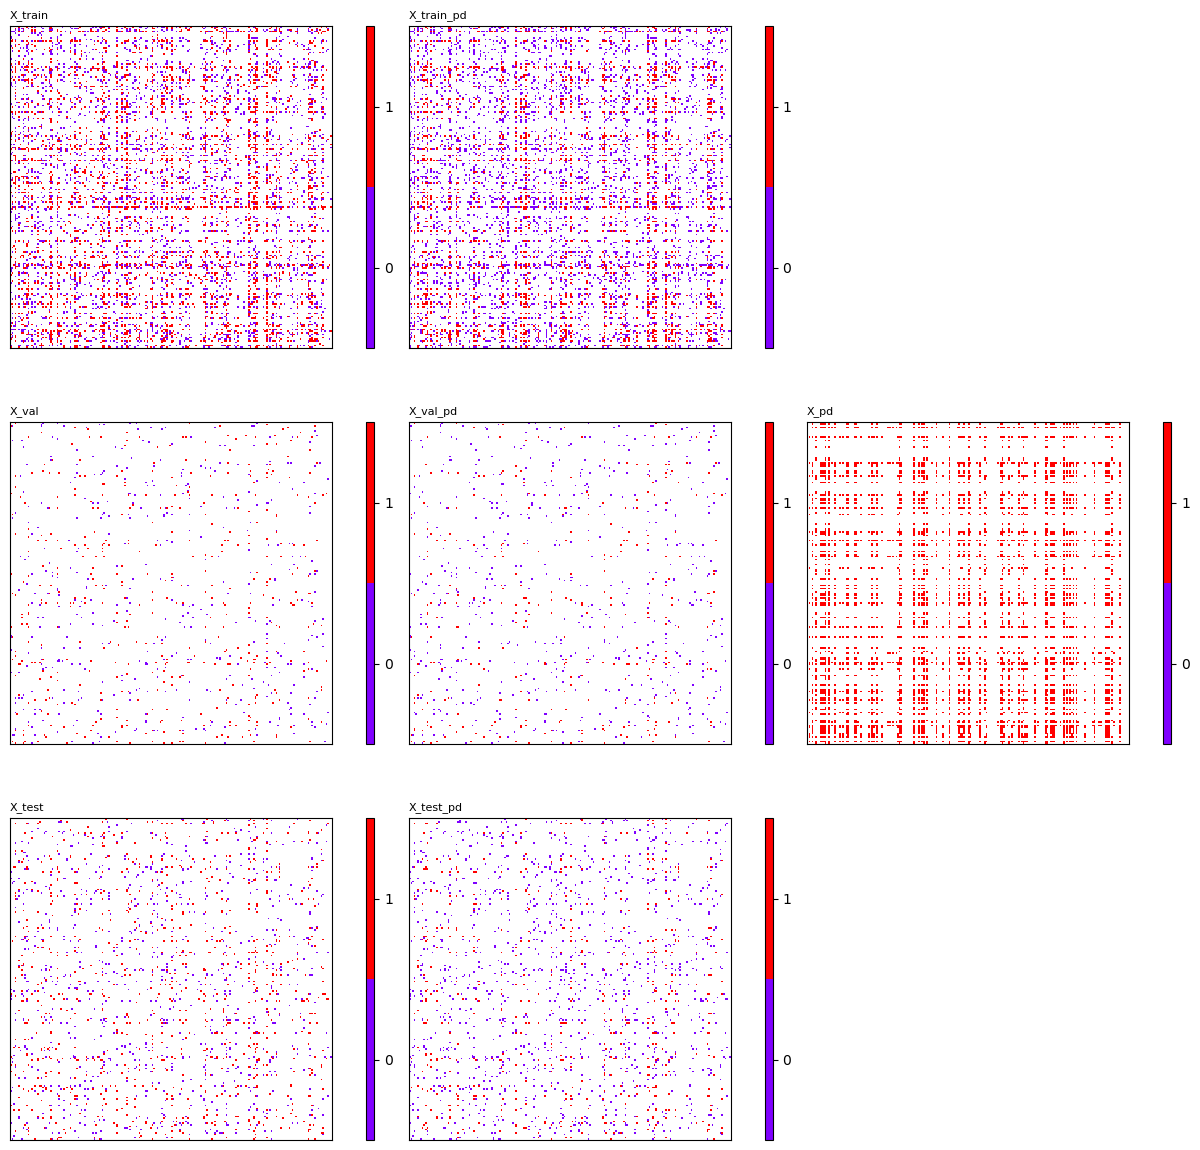

In [39]:
from utils import matmul, fill_nan

U, V = asso.U[:, :4], asso.V[:, :4]
X_pd = matmul(U, V.T, sparse=True, boolean=True)

X_train_pd = fill_nan(X_pd, X_train)
X_val_pd = fill_nan(X_pd, X_val)
X_test_pd = fill_nan(X_pd, X_test)

rng = [200, 200]
settings = [(X_train[:rng[0], :rng[1]],     [0, 0], 'X_train'), 
            (X_train_pd[:rng[0], :rng[1]],  [0, 1], 'X_train_pd'), 
            (X_val[:rng[0], :rng[1]],       [1, 0], 'X_val'), 
            (X_val_pd[:rng[0], :rng[1]],    [1, 1], 'X_val_pd'), 
            (X_test[:rng[0], :rng[1]],      [2, 0], 'X_test'), 
            (X_test_pd[:rng[0], :rng[1]],   [2, 1], 'X_test_pd'), 
            (X_pd[:rng[0], :rng[1]],        [1, 2], 'X_pd'), 
            ]

show_matrix(settings=settings, keep_nan=True, scaling=2, 
            clim=[0, 1], colorbar=True, discrete=True, center=True)

In [42]:
asso.logs['updates_X_train']

,time,k,iter,score,Recall,Precision,Accuracy,F1
0,28/02/24 04:30:03,0,0,853.00,0.279875,0.666210,0.569825,0.394162
1,28/02/24 04:30:12,0,1,1356.50,0.292047,0.719263,0.589029,0.415419
2,28/02/24 04:30:22,0,2,1437.00,0.313595,0.716191,0.594662,0.436195
3,28/02/24 04:30:32,0,3,1438.00,0.313677,0.715975,0.594621,0.436235
4,28/02/24 04:30:41,0,4,1438.50,0.312361,0.716874,0.594498,0.435126
5,28/02/24 04:30:51,0,5,1438.75,0.315322,0.714898,0.594786,0.437621
6,28/02/24 04:31:03,0,6,1439.25,0.318118,0.714048,0.595361,0.440146
7,28/02/24 04:31:37,1,0,1544.50,0.340571,0.715817,0.602681,0.461547
8,28/02/24 04:31:47,1,1,1606.25,0.364010,0.716297,0.609919,0.482713
9,28/02/24 04:32:15,1,2,1650.75,0.379554,0.709563,0.612098,0.494561
